In [2]:
import json
from pycocotools.coco import COCO
import os
import numpy as np
from pose_utils import world2cam, cam2pixel, pixel2cam, rigid_align, process_bbox
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
dir_joint = '/home/kiddhcx/Downloads/annotations/Human36M_subject1_joint_3d.json'
dir_data = '/home/kiddhcx/Downloads/annotations/Human36M_subject1_data.json'
dir_camera = '/home/kiddhcx/Downloads/annotations/Human36M_subject1_camera.json'

In [4]:
joint_num = 18
joints_name = ('Pelvis', 'R_Hip', 'R_Knee', 'R_Ankle', 'L_Hip', 'L_Knee', 'L_Ankle', 'Torso', 'Neck', 'Nose', 'Head', 'L_Shoulder', 'L_Elbow', 'L_Wrist', 'R_Shoulder', 'R_Elbow', 'R_Wrist', 'Thorax')
lshoulder_idx = joints_name.index('L_Shoulder')
rshoulder_idx = joints_name.index('R_Shoulder')
root_idx = joints_name.index('Pelvis')

In [5]:
def add_thorax(joint_coord):
    thorax = (joint_coord[lshoulder_idx, :] + joint_coord[rshoulder_idx, :]) * 0.5
    thorax = thorax.reshape((1, 3))
    joint_coord = np.concatenate((joint_coord, thorax), axis=0)
    return joint_coord

In [6]:
def load_data(dir_joint, dir_data, dir_camera):
    # aggregate annotations from each subject
    db = COCO()
    cameras = {}
    joints = {}
    
    # data load
    with open(dir_data,'r') as f:
        annot = json.load(f)
    if len(db.dataset) == 0:
        for k,v in annot.items():
            db.dataset[k] = v
    else:
        for k,v in annot.items():
            db.dataset[k] += v
    # camera load
    with open(dir_camera,'r') as f:
        cameras = json.load(f)
    # joint coordinate load
    with open(dir_joint, 'r') as f:
        joints = json.load(f)
    db.createIndex()

    data = []
    for aid in db.anns.keys():
        ann = db.anns[aid]
        image_id = ann['image_id']
        img = db.loadImgs(image_id)[0]
        img_width, img_height = img['width'], img['height']

        # camera parameter
        cam_idx = img['cam_idx']
        cam_param = cameras[str(cam_idx)]
        R,t,f,c = np.array(cam_param['R'], dtype=np.float32), np.array(cam_param['t'], dtype=np.float32), np.array(cam_param['f'], dtype=np.float32), np.array(cam_param['c'], dtype=np.float32)
            
        # project world coordinate to cam, image coordinate space
        action_idx = img['action_idx']; subaction_idx = img['subaction_idx']; frame_idx = img['frame_idx'];
        joint_world = np.array(joints[str(action_idx)][str(subaction_idx)][str(frame_idx)], dtype=np.float32)
        joint_world = add_thorax(joint_world)
        joint_cam = world2cam(joint_world, R, t)
        joint_img = cam2pixel(joint_cam, f, c)
        joint_img[:,2] = joint_img[:,2] - joint_cam[root_idx,2]
        joint_vis = np.ones((joint_num,1))
        

        bbox = process_bbox(np.array(ann['bbox']), img_width, img_height)
        if bbox is None: continue
        root_cam = joint_cam[root_idx]
            
        data.append({
            'img_id': image_id,
            'bbox': bbox,
            'joint_img': joint_img, # [org_img_x, org_img_y, depth - root_depth]
            'joint_cam': joint_cam, # [X, Y, Z] in camera coordinate
            'joint_vis': joint_vis,
            'root_cam': root_cam, # [X, Y, Z] in camera coordinate
            'f': f,
            'c': c,
            'joint_world':joint_world,
            'cam_idx':cam_idx,
            'action_name': img['action_name']})
        
    
    return data

In [7]:
d = load_data(dir_joint, dir_data, dir_camera)

creating index...
index created!


In [8]:
H36M_NAMES = ['']*18
H36M_NAMES[0]  = 'Pelvis'
H36M_NAMES[1]  = 'R_Hip'
H36M_NAMES[2]  = 'R_Knee'
H36M_NAMES[3]  = 'R_Ankle'
H36M_NAMES[4]  = 'L_Hip'
H36M_NAMES[5]  = 'L_Knee'
H36M_NAMES[6]  = 'L_Ankle'
H36M_NAMES[7] = 'Torso'
H36M_NAMES[8] = 'Neck'
H36M_NAMES[9] = 'Nose'
H36M_NAMES[10] = 'Head'
H36M_NAMES[11] = 'L_Shoulder'
H36M_NAMES[12] = 'L_Elbow'
H36M_NAMES[13] = 'L_Wrist'
H36M_NAMES[14] = 'R_Shoulder'
H36M_NAMES[15] = 'R_Elbow'
H36M_NAMES[16] = 'R_Wrist'
H36M_NAMES[17] = 'Thorax'

In [21]:
def drawskeleton(channels, ax, lcolor='#ff0000', rcolor='#0000ff'):
    vals = channels
    connections = [[0, 7], [7, 8], [8, 9], [9, 10], [8, 11], [11, 12], [12, 13], [8, 14], [14, 15], [15, 16], [0, 1], [1, 2], [2, 3], [0, 4], [4, 5], [5, 6]]

    LR = np.array([0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1], dtype=bool)

    for ind, (i,j) in enumerate(connections):
        x, y, z = [np.array([vals[i, c], vals[j, c]]) for c in range(3)]
        ax.plot3D(x, y, z, lw=2, c=lcolor if LR[ind] else rcolor)

    
    xroot, yroot, zroot = vals[0, 0], vals[0, 1], vals[0, 2]
    ax.set_xlim3d([-1000, 1000])
    ax.set_zlim3d([3000, 6000])
    ax.set_ylim3d([-1000 , 1000])

    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")


In [13]:
low = d[0]['joint_cam'][3][1]
a = 0
for i in range(len(d)):
    if low < max(d[i]['joint_cam'][3][1],d[i]['joint_cam'][6][1]):
        low = max(d[i]['joint_cam'][3][1],d[i]['joint_cam'][6][1])
        a = i
print(a)
print(low)

212333
968.26843


In [17]:
print(d[212333]['joint_cam'])

[[  81.62976   101.689606 3055.9104  ]
 [ 103.10211   106.35339  2924.7898  ]
 [   8.080994  524.02203  3037.3938  ]
 [-274.4301    869.18445  3123.148   ]
 [  60.15747    97.02588  3187.0308  ]
 [ 190.87494   520.1906   3186.7869  ]
 [ 253.77838   968.26843  3147.1245  ]
 [  61.138885 -128.17773  3020.5186  ]
 [  74.891205 -383.2788   2991.8257  ]
 [ 136.03967  -486.94244  3005.5508  ]
 [  65.32477  -573.7691   2979.3586  ]
 [  34.441345 -334.66656  3128.9824  ]
 [ -69.304016 -126.46521  3282.816   ]
 [-173.28552    60.566986 3415.3926  ]
 [ 100.04932  -294.3457   2872.375   ]
 [ 165.25021   -29.36792  2814.783   ]
 [ 290.06104   188.92938  2803.1262  ]
 [  67.24536  -314.50623  3000.6787  ]]


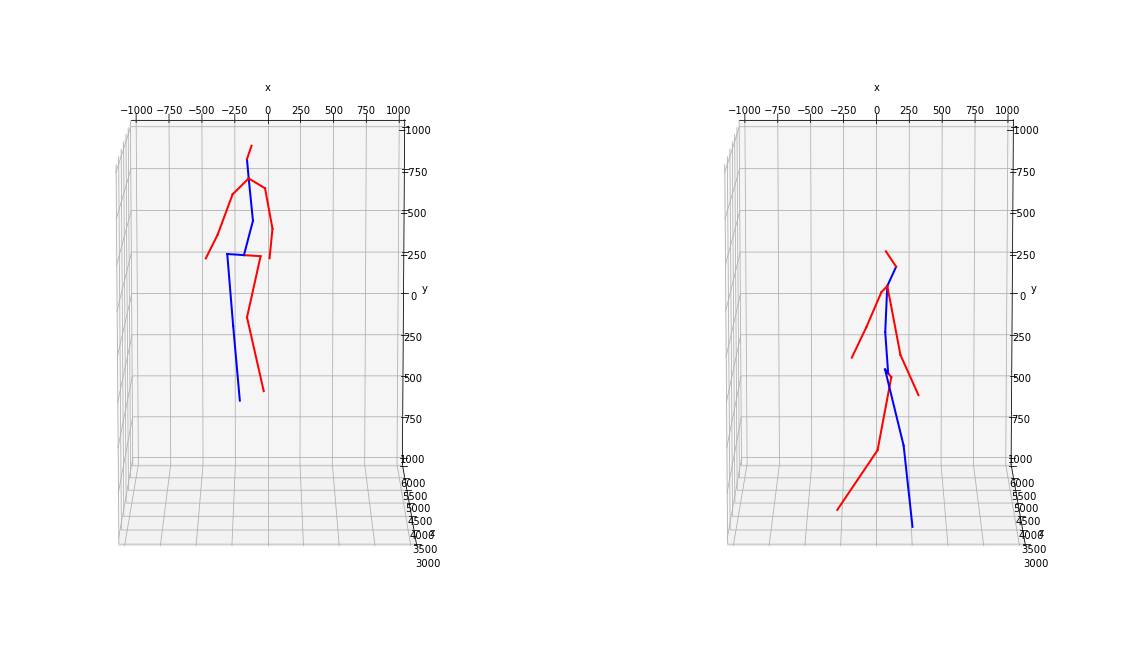

In [22]:
fig = plt.figure(figsize=(20,12))
ax = fig.add_subplot('121', projection='3d')
img = d[0]['joint_cam']
drawskeleton(img, ax)
ax.view_init(-80,-90)
ax = fig.add_subplot('122', projection='3d')
img = d[212333]['joint_cam']
drawskeleton(img, ax)
ax.view_init(-80,-90)

In [17]:
import cv2
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl



In [59]:
def vis_3d_skeleton(kpt_3d, kpt_3d_vis, kps_lines, filename=None):

    fig = plt.figure(figsize=(15,15))
    ax = fig.add_subplot(111, projection='3d')

    # Convert from plt 0-1 RGBA colors to 0-255 BGR colors for opencv.
    cmap = plt.get_cmap('rainbow')
    colors = [cmap(i) for i in np.linspace(0, 1, len(kps_lines) + 2)]
    colors = [np.array((c[2], c[1], c[0])) for c in colors]

    for l in range(len(kps_lines)):
        i1 = kps_lines[l][0]
        i2 = kps_lines[l][1]
        x = np.array([kpt_3d[i1,0], kpt_3d[i2,0]])
        y = np.array([kpt_3d[i1,1], kpt_3d[i2,1]])
        z = np.array([kpt_3d[i1,2], kpt_3d[i2,2]])


        if kpt_3d_vis[i1,0] > 0 and kpt_3d_vis[i2,0] > 0:
            ax.plot(x, z, -y, c=colors[l], linewidth=2)
        if kpt_3d_vis[i1,0] > 0:
            ax.scatter(kpt_3d[i1,0], kpt_3d[i1,2], -kpt_3d[i1,1], c=colors[l], marker='o')
        if kpt_3d_vis[i2,0] > 0:
            ax.scatter(kpt_3d[i2,0], kpt_3d[i2,2], -kpt_3d[i2,1], c=colors[l], marker='o')

    if filename is None:
        ax.set_title('3D vis')
    else:
        ax.set_title(filename)

    ax.set_xlabel('X Label')
    ax.set_ylabel('Z Label')
    ax.set_zlabel('Y Label')
    ax.legend()
    
    plt.show()
    cv2.waitKey(0)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

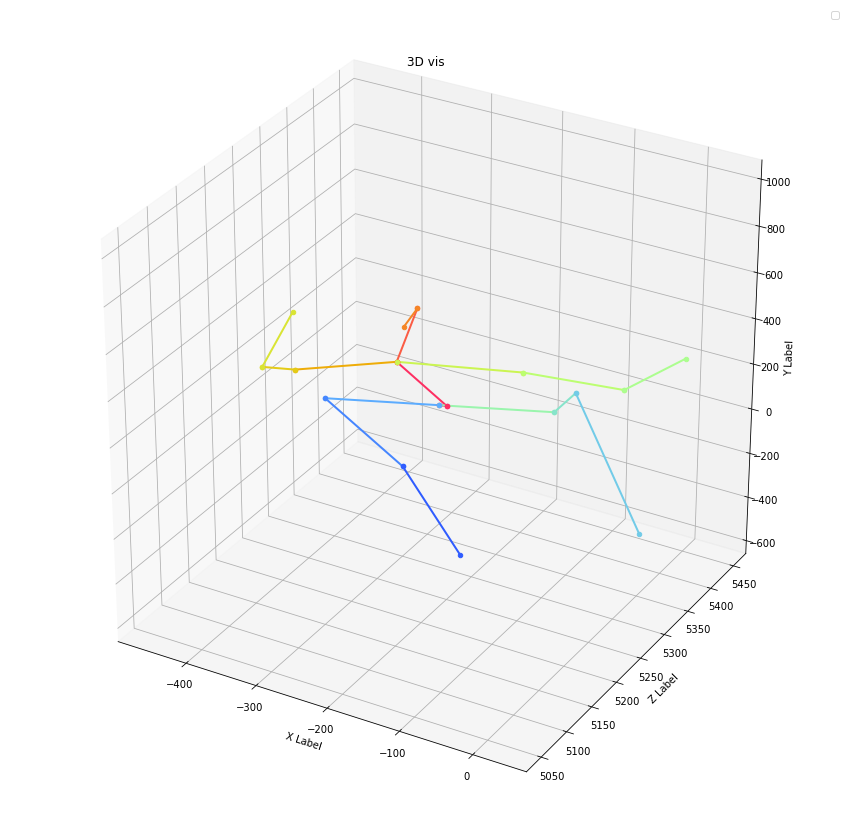

In [60]:
skeleton = ( (0, 7), (7, 8), (8, 9), (9, 10), (8, 11), (11, 12), (12, 13), (8, 14), (14, 15), (15, 16), (0, 1), (1, 2), (2, 3), (0, 4), (4, 5), (5, 6) )

kpt_3d = d[0]['joint_cam']
kpt_3d_vis = d[0]['joint_vis']

vis_3d_skeleton(kpt_3d,kpt_3d_vis,skeleton)